In [1]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [7]:
import os
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, IterableDataset
from sentence_transformers import SentenceTransformer
from tqdm import tqdm

In [3]:
os.chdir('..')
# os.chdir('drive/My Drive/Colab Notebooks/Github/fashion-recommendations') 

In [4]:
from fashion_recommendations.metrics.average_precision import mapk

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [8]:
class RecommendationDatasetMultiLabel(IterableDataset):

    def __init__(self, dataset_filepath, article_emb_bag, total_articles):
        
        self.dataset_itr = open(dataset_filepath, 'r')
        next(self.dataset_itr)  # skip header
        
        self.article_emb_bag = article_emb_bag
        
        self.total_articles = total_articles
    
    def process_label(self, label_str: str):
        
        labels = torch.tensor([int(v) for v in label_str.split(',')])
        
        target = torch.zeros(self.total_articles).scatter_(0, labels, 1.)

        return target
    
    def mean_historical_purchases_embedding(self, input_str: str):
        
        indices = torch.tensor([int(v) for v in input_str.split(',')])

        mean_emb = self.article_emb_bag(indices.unsqueeze(0)).flatten()
            
        return mean_emb
    
    def process_numeric_features(self, fn: str, active: str, age: str):
        numeric_features_tensor = torch.tensor([
            float(fn),
            float(active),
            float(age)
        ])

        return numeric_features_tensor
    
    def parse_itr(self, dataset_itr):
        
        for line in dataset_itr:
        
            line_items = line.rstrip('\n').split('\t')
            
            customer_id_idx, article_id_idx_last10, article_id_idx_label, fn, active, age = line_items
            
            customer_id_idx = int(customer_id_idx)
            
            numeric_features_tensor = self.process_numeric_features(fn, active, age)
            
            mean_emb = self.mean_historical_purchases_embedding(article_id_idx_last10)

            label = self.process_label(article_id_idx_label)    
            
            inputs = torch.concat((mean_emb, numeric_features_tensor))

            yield customer_id_idx, inputs, label
        
    def get_stream(self, dataset_itr):
        
        return self.parse_itr(dataset_itr)

    def __iter__(self):
        
        return self.get_stream(self.dataset_itr)

In [11]:
articles_df = pd.read_csv('data/articles_df_filt.csv', dtype={'article_id': str})
print(articles_df.shape)
articles_df.head()

(40538, 3)


,article_id,detail_desc,article_id_idx
0,0108775015,Jersey top with narrow shoulder straps.,0
1,0108775044,Jersey top with narrow shoulder straps.,1
2,0110065001,"Microfibre T-shirt bra with underwired, moulde...",2
3,0110065002,"Microfibre T-shirt bra with underwired, moulde...",3
4,0110065011,"Microfibre T-shirt bra with underwired, moulde...",4


In [12]:
customers = pd.read_csv('data/customers_filt.csv')
print(customers.shape)
customers.head()

(43108, 5)


,customer_id,FN,Active,age,customer_id_idx
0,000172a9c322560c849754ffbdfdb2180d408aa7176b94...,0.0,0.0,0.45,0
1,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,1.0,1.0,0.44,1
2,0001f8cef6b9702d54abf66fd89eb21014bf98567065a9...,0.0,0.0,0.21,2
3,0003e867a930d0d6842f923d6ba7c9b77aba33fe2a0fbf...,1.0,1.0,0.33,3
4,0005340aa69bb5a28d98712a36d8f669024bce137e3c82...,0.0,0.0,0.21,4


### Create article EmbeddingBag

In [ ]:
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

In [67]:
article_descriptions = articles_df['detail_desc'].to_list()
article_descriptions[:5]

['Jersey top with narrow shoulder straps.',
 'Jersey top with narrow shoulder straps.',
 'Jersey top with narrow shoulder straps.',
 'Microfibre T-shirt bra with underwired, moulded, lightly padded cups that shape the bust and provide good support. Narrow adjustable shoulder straps and a narrow hook-and-eye fastening at the back. Without visible seams for greater comfort.',
 'Microfibre T-shirt bra with underwired, moulded, lightly padded cups that shape the bust and provide good support. Narrow adjustable shoulder straps and a narrow hook-and-eye fastening at the back. Without visible seams for greater comfort.']

In [68]:
embeddings = model.encode(article_descriptions)

In [69]:
embeddings = torch.tensor(embeddings)

In [70]:
embeddings.shape

torch.Size([105542, 384])

### TBD

In [14]:
embeddings = torch.randn(len(articles_df), 384)
embeddings.shape

torch.Size([40538, 384])

In [15]:
ARTICLE_EMBEDDING_BAG = nn.EmbeddingBag.from_pretrained(embeddings=embeddings, freeze=True)

### Model

In [39]:
class FashionRecV3(nn.Module):

    def __init__(self, user_embedding_dim):
        super(FashionRecV3, self).__init__()
        
        # Embeddings
        self.user_embeddings = nn.Embedding(num_embeddings=len(customers), embedding_dim=user_embedding_dim)        
        
        # Initialise embeddings
        torch.nn.init.xavier_uniform_(self.user_embeddings.weight)
        
        # FC layers
        self.fc_1 = nn.Linear(in_features=user_embedding_dim+384+3, out_features=512)            
        self.fc_2 = nn.Linear(in_features=512, out_features=256)
        self.fc_3 = nn.Linear(in_features=256, out_features=len(articles_df))
        
        # Activation functions
        self.relu = nn.ReLU()
        
        # Dropout
        self.dropout = nn.Dropout(0.2)
        
    def forward(
        self, 
        customer_id_idx, 
        inputs
    ):

        user_emb = self.user_embeddings(customer_id_idx)
              
        concatenated_features = torch.concat(
            [
                user_emb, 
                inputs
            ], 
            dim=1
        )
        
        x = self.fc_1(concatenated_features)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc_2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc_3(x)

        return x

In [55]:
fashion_rec_v3 = FashionRecV3(user_embedding_dim=384)

In [56]:
fashion_rec_v3.to(device)

FashionRecV3(
  (user_embeddings): Embedding(43108, 384)
  (fc_1): Linear(in_features=771, out_features=512, bias=True)
  (fc_2): Linear(in_features=512, out_features=256, bias=True)
  (fc_3): Linear(in_features=256, out_features=40538, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)

In [57]:
BATCH_SIZE = 512

In [58]:
total_training_examples = pd.read_csv('data/final_train_set.tsv', sep='\t').shape[0]
total_batches = np.ceil(total_training_examples/BATCH_SIZE)
total_batches

85.0

In [61]:
total_dev_examples = pd.read_csv('data/final_dev_set.tsv', sep='\t').shape[0]
total_dev_batches = np.ceil(total_dev_examples/BATCH_SIZE)
total_dev_batches

18.0

In [59]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=fashion_rec_v3.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [223]:
MAX_EPOCHS = 3

training_losses = []
dev_losses = []

for epoch in range(MAX_EPOCHS):
    
    # Since we use an IterableDataset we need to reinstaniate the dataset since file end will have been reached:
    train_dataset = RecommendationDatasetMultiLabel(dataset_filepath='data/final_train_set.tsv', article_emb_bag=ARTICLE_EMBEDDING_BAG, total_articles=len(articles_df))    
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)  
    
    for data in tqdm(train_loader, total=total_batches):
        
        customer_id_idx, inputs, label = data
        customer_id_idx, inputs, label = customer_id_idx.to(device), inputs.to(device), label.to(device)

        optimizer.zero_grad()  # Set gradients to 0 otherwise will accumulate

        y_pred = fashion_rec_v3(customer_id_idx, inputs)
        
        loss = criterion(y_pred, label)

        loss.backward()    
        
        optimizer.step()
        
    scheduler.step()
    
    # Compute train loss:
    
    total_train_loss = 0

    fashion_rec_v3.eval()
    
    train_dataset = RecommendationDatasetMultiLabel(dataset_filepath='data/final_train_set.tsv', article_emb_bag=ARTICLE_EMBEDDING_BAG, total_articles=len(articles_df))    
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)  
    
    with torch.no_grad():
        for data in tqdm(train_loader, total=total_batches):

            customer_id_idx, inputs, label = data
            customer_id_idx, inputs, label = customer_id_idx.to(device), inputs.to(device), label.to(device)

            optimizer.zero_grad()  # Set gradients to 0 otherwise will accumulate

            y_pred = fashion_rec_v3(customer_id_idx, inputs)

            loss = nn.BCEWithLogitsLoss(reduction='sum')(y_pred, label)

            total_train_loss += loss.item()

        mean_train_loss = total_train_loss / total_training_examples
        print(f"Training loss: {mean_train_loss}")
        training_losses.append(mean_train_loss)
        
    # Compute dev loss:
    
    total_dev_loss = 0
    
    dev_dataset = RecommendationDatasetMultiLabel(dataset_filepath='data/final_dev_set.tsv', article_emb_bag=ARTICLE_EMBEDDING_BAG, total_articles=len(articles_df))    
    
    dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE)  
    
    with torch.no_grad():
        for data in tqdm(dev_loader, total=total_dev_batches):

            customer_id_idx, inputs, label = data
            customer_id_idx, inputs, label = customer_id_idx.to(device), inputs.to(device), label.to(device)

            optimizer.zero_grad()  # Set gradients to 0 otherwise will accumulate

            y_pred = fashion_rec_v3(customer_id_idx, inputs)

            loss = nn.BCEWithLogitsLoss(reduction='sum')(y_pred, label)

            total_dev_loss += loss.item()

        mean_dev_loss = total_train_loss / total_dev_examples
        print(f"Dev loss: {mean_dev_loss}")
        dev_losses.append(mean_dev_loss)
        
    fashion_rec_v3.train()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 85/85.0 [01:23<00:00,  1.02it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 85/85.0 [00:41<00:00,  2.03it/s]


Training loss: 41.54665629965726


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18.0 [00:08<00:00,  2.00it/s]


Dev loss: 196.3808398865817


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 85/85.0 [01:16<00:00,  1.11it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 85/85.0 [00:37<00:00,  2.24it/s]


Training loss: 39.93602777109237


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18.0 [00:08<00:00,  2.08it/s]


Dev loss: 188.7677944250274


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 85/85.0 [01:12<00:00,  1.17it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 85/85.0 [00:37<00:00,  2.26it/s]


Training loss: 38.66214220043988


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18.0 [00:07<00:00,  2.26it/s]

Dev loss: 182.74645021672833


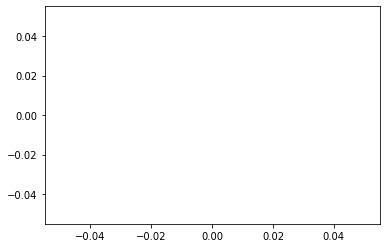

In [240]:
plt.plot(training_losses)

In [224]:
fashion_rec_v3.eval()

predictions = []

dev_dataset = RecommendationDatasetMultiLabel(dataset_filepath='data/final_train_set.tsv', article_emb_bag=ARTICLE_EMBEDDING_BAG, total_articles=len(articles_df))    

dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE)  

with torch.no_grad():
    for data in tqdm(dev_loader, total=total_batches):

        customer_id_idx, inputs, label = data
        customer_id_idx, inputs, label = customer_id_idx.to(device), inputs.to(device), label.to(device)

        optimizer.zero_grad()  # Set gradients to 0 otherwise will accumulate

        y_pred = fashion_rec_v3(customer_id_idx, inputs)
        
        predictions.append(y_pred.topk(12, dim=1).indices)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 85/85.0 [00:21<00:00,  4.01it/s]


In [225]:
predictions = torch.concat(predictions)

In [226]:
predictions.shape

torch.Size([43108, 12])

In [227]:
actuals = pd.read_csv('data/final_train_set.tsv', sep='\t')['article_id_idx_label'].apply(lambda x: [int(i) for i in x.split(',')]).tolist()
len(actuals)

43108

In [228]:
mapk(actuals, predictions.tolist(), 12)

0.010127502723454597

In [229]:
fashion_rec_v3.eval()

predictions = []

dev_dataset = RecommendationDatasetMultiLabel(dataset_filepath='data/final_dev_set.tsv', article_emb_bag=ARTICLE_EMBEDDING_BAG, total_articles=len(articles_df))    

dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE)  

with torch.no_grad():
    for data in tqdm(dev_loader, total=total_dev_batches):

        customer_id_idx, inputs, label = data
        customer_id_idx, inputs, label = customer_id_idx.to(device), inputs.to(device), label.to(device)

        y_pred = fashion_rec_v3(customer_id_idx, inputs)
        
        predictions.append(y_pred.topk(12, dim=1).indices)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18.0 [00:04<00:00,  4.03it/s]


In [230]:
predictions = torch.concat(predictions)

In [231]:
predictions.shape

torch.Size([9120, 12])

In [232]:
actuals = pd.read_csv('data/final_dev_set.tsv', sep='\t')['article_id_idx_label'].apply(lambda x: [int(i) for i in x.split(',')]).tolist()
len(actuals)

9120

In [233]:
mapk(actuals, predictions.tolist(), 12)

0.006182140938050895

In [234]:
total_test_batches = np.ceil(pd.read_csv('data/final_test_set.tsv', sep='\t').shape[0]/BATCH_SIZE)

In [235]:
fashion_rec_v3.eval()

predictions = []

dev_dataset = RecommendationDatasetMultiLabel(dataset_filepath='data/final_test_set.tsv', article_emb_bag=ARTICLE_EMBEDDING_BAG, total_articles=len(articles_df))    

dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE)  

with torch.no_grad():
    for data in tqdm(dev_loader, total=total_test_batches):

        customer_id_idx, inputs, label = data
        customer_id_idx, inputs, label = customer_id_idx.to(device), inputs.to(device), label.to(device)

        y_pred = fashion_rec_v3(customer_id_idx, inputs)
        
        predictions.append(y_pred.topk(12, dim=1).indices)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18.0 [00:04<00:00,  4.27it/s]


In [236]:
predictions = torch.concat(predictions)

In [237]:
predictions.shape

torch.Size([8733, 12])

In [238]:
actuals = pd.read_csv('data/final_test_set.tsv', sep='\t')['article_id_idx_label'].apply(lambda x: [int(i) for i in x.split(',')]).tolist()
len(actuals)

8733

In [239]:
mapk(actuals, predictions.tolist(), 12)

0.005902365759503163

### Submission

In [197]:
total_sub_batches = np.ceil(pd.read_csv('data/final_submission_inputs.tsv', sep='\t').shape[0]/BATCH_SIZE)
total_sub_batches

85.0

In [198]:
fashion_rec_v3.eval()

predictions = []

dev_dataset = RecommendationDatasetMultiLabel(dataset_filepath='data/final_submission_inputs.tsv', article_emb_bag=ARTICLE_EMBEDDING_BAG, total_articles=len(articles_df))    

dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE)  

with torch.no_grad():
    for data in tqdm(dev_loader, total=total_sub_batches):

        customer_id_idx, inputs, label = data
        customer_id_idx, inputs, label = customer_id_idx.to(device), inputs.to(device), label.to(device)

        y_pred = fashion_rec_v3(customer_id_idx, inputs)
        
        predictions.append(y_pred.topk(12, dim=1).indices)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 85/85.0 [00:21<00:00,  3.94it/s]


In [199]:
predictions = torch.concat(predictions)

In [200]:
predictions.shape

torch.Size([43108, 12])

In [201]:
sample_submission = pd.read_csv('data/sample_submission.csv')
print(sample_submission.shape)
sample_submission.head()

(1371980, 2)


,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0706016001 0706016002 0372860001 0610776002 07...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0706016001 0706016002 0372860001 0610776002 07...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0706016001 0706016002 0372860001 0610776002 07...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0706016001 0706016002 0372860001 0610776002 07...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0706016001 0706016002 0372860001 0610776002 07...


In [202]:
article_idx_to_id = dict(zip(articles_df['article_id_idx'], articles_df['article_id']))

In [203]:
predictions_article_id = [[article_idx_to_id[i] for i in l] for l in predictions.tolist()]
predictions_article_id[0]

['0915526001',
 '0915529003',
 '0751471001',
 '0751471043',
 '0919365008',
 '0896152002',
 '0918292001',
 '0863595006',
 '0706016001',
 '0898694001',
 '0916468001',
 '0865929003']

In [204]:
predictions_strings = [' '.join(l) for l in predictions_article_id]
predictions_strings[0]

'0915526001 0915529003 0751471001 0751471043 0919365008 0896152002 0918292001 0863595006 0706016001 0898694001 0916468001 0865929003'

In [205]:
submission_set_filt = pd.read_csv('data/final_submission_inputs.tsv', sep='\t')
print(submission_set_filt.shape)
submission_set_filt.head()

(43108, 6)


,customer_id_idx,article_id_idx_last10,article_id_idx_label,FN,Active,age
0,0,"15861,7705,7705,7705",0,0.0,0.0,0.45
1,1,"17255,26222,39644,31316,3160,38515,39642,40340...",0,1.0,1.0,0.44
2,2,"21627,21175,23351,23816",0,0.0,0.0,0.21
3,3,"36213,38872,37897,38110,5642,4783,34346,34346,...",0,1.0,1.0,0.33
4,4,"21522,31083,23930,15224,21141,37733,10396,3782...",0,0.0,0.0,0.21


In [206]:
len(predictions_strings)

43108

In [207]:
customer_idx_to_id = dict(zip(customers['customer_id_idx'], customers['customer_id']))

In [208]:
submission_set_filt['customer_id'] = submission_set_filt['customer_id_idx'].map(customer_idx_to_id)

In [209]:
submission_set_filt['prediction_model'] = predictions_strings

In [210]:
submission_set_filt.isnull().sum()

customer_id_idx          0
article_id_idx_last10    0
article_id_idx_label     0
FN                       0
Active                   0
age                      0
customer_id              0
prediction_model         0
dtype: int64

In [211]:
submission_set_filt.head()

,customer_id_idx,article_id_idx_last10,article_id_idx_label,FN,Active,age,customer_id,prediction_model
0,0,"15861,7705,7705,7705",0,0.0,0.0,0.45,000172a9c322560c849754ffbdfdb2180d408aa7176b94...,0915526001 0915529003 0751471001 0751471043 09...
1,1,"17255,26222,39644,31316,3160,38515,39642,40340...",0,1.0,1.0,0.44,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,0915526001 0751471001 0915529003 0751471043 09...
2,2,"21627,21175,23351,23816",0,0.0,0.0,0.21,0001f8cef6b9702d54abf66fd89eb21014bf98567065a9...,0915526001 0915529003 0751471001 0751471043 09...
3,3,"36213,38872,37897,38110,5642,4783,34346,34346,...",0,1.0,1.0,0.33,0003e867a930d0d6842f923d6ba7c9b77aba33fe2a0fbf...,0915526001 0915529003 0751471001 0751471043 09...
4,4,"21522,31083,23930,15224,21141,37733,10396,3782...",0,0.0,0.0,0.21,0005340aa69bb5a28d98712a36d8f669024bce137e3c82...,0915526001 0751471001 0751471043 0915529003 09...


In [212]:
sample_submission = sample_submission.merge(submission_set_filt[['customer_id', 'prediction_model']], on='customer_id', how='left')
sample_submission.head()

,customer_id,prediction,prediction_model
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0706016001 0706016002 0372860001 0610776002 07...,NaN
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0706016001 0706016002 0372860001 0610776002 07...,NaN
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0706016001 0706016002 0372860001 0610776002 07...,NaN
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0706016001 0706016002 0372860001 0610776002 07...,NaN
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0706016001 0706016002 0372860001 0610776002 07...,NaN


In [213]:
sample_submission.isnull().sum()

customer_id               0
prediction                0
prediction_model    1328872
dtype: int64

In [214]:
sample_submission['prediction_model'].fillna(
    '0751471001 0706016001 0372860002 0610776002 0448509014 0730683050 0918292001 0760084003 0866731001 0372860001 0827968001 0706016003',
    inplace=True
)

In [215]:
sample_submission.drop(columns=['prediction'], inplace=True)
sample_submission.rename(columns={'prediction_model': 'prediction'}, inplace=True)

In [216]:
sample_submission

,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0751471001 0706016001 0372860002 0610776002 04...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0751471001 0706016001 0372860002 0610776002 04...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0751471001 0706016001 0372860002 0610776002 04...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0751471001 0706016001 0372860002 0610776002 04...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0751471001 0706016001 0372860002 0610776002 04...
...,...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,0915526001 0751471043 0751471001 0915529003 09...
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,0751471001 0706016001 0372860002 0610776002 04...
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,0751471001 0706016001 0372860002 0610776002 04...
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,0751471001 0706016001 0372860002 0610776002 04...


In [217]:
sample_submission.to_csv('submissions/20220502-fashionrecv3.csv', index=False)

In [218]:
# sample_submission['prediction'] = '0751471001 0706016001 0372860002 0610776002 0448509014 0730683050 0918292001 0760084003 0866731001 0372860001 0827968001 0706016003'

In [220]:
# sample_submission.to_csv('submissions/20220502-top12-recent-period.csv', index=False)